In [1]:
import numpy

from assemblyfire import utility, assemblies
from matplotlib import pyplot as plt


In [2]:
fn = "/home/reimann/Documents/data/plasticity/assemblies_stream_0p90_20trials.h5"
assembly_groups, metadata = utility.load_assemblies_from_h5(fn)

print(assembly_groups.keys())
print(metadata)


dict_keys(['seed137353', 'seed221978', 'seed249122', 'seed253694', 'seed28521', 'seed317066', 'seed345044', 'seed348646', 'seed461997', 'seed483057', 'seed551584', 'seed561919', 'seed586021', 'seed644904', 'seed708802', 'seed717531', 'seed737026', 'seed788761', 'seed791562', 'seed901182'])
{'proj_root': '/gpfs/bbp.cscs.ch/project/proj96/home/ecker/simulations/random_stream_0p90_20trials', 'seeds': array([586021, 644904, 253694, 788761, 249122, 901182, 137353, 551584,
       345044, 221978, 561919, 791562, 317066, 461997, 737026, 483057,
        28521, 708802, 717531, 348646])}


0. Quick demo of ways to instantiate AssemblyGroups directly

In [3]:
# By using a binary matrix of assembly membership
demo = assemblies.AssemblyGroup(numpy.array([[False, True],
                                             [True, True],
                                             [False, False]]),
                                [123, 456, 789], label="Demo")
print(demo.to_dict())
# By directly providing a list of Assembly objects
demo2 = assemblies.AssemblyGroup([assemblies.Assembly([456], index=0),
                                 assemblies.Assembly([123, 456], index=1)],
                                [123, 456, 789], label="Demo")
print(demo2.to_dict())


{'label': 'Demo', 'all_gids': [123, 456, 789], 'assemblies': [{'gids': array([456]), 'idx': 0}, {'gids': array([123, 456]), 'idx': 1}], 'metadata': {}}
{'label': 'Demo', 'all_gids': [123, 456, 789], 'assemblies': [{'gids': array([456]), 'idx': 0}, {'gids': array([123, 456]), 'idx': 1}], 'metadata': {}}


1. Simply align all other seeds to one randomly picked reference seed

In [4]:
reference_name = 'seed137353'
reference = assembly_groups[reference_name]
aligned = [reference.align_with(assembly_grp)
           for assembly_name, assembly_grp in assembly_groups.items()
          if assembly_name != reference_name]

print(reference.iloc(0).to_dict())

{'gids': array([66469, 66483, 66492, ..., 93962, 93980, 94003]), 'idx': 0}


Demo of consensus Assebmlies

0
5722
899


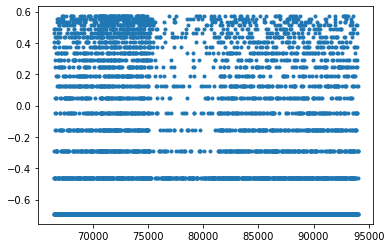

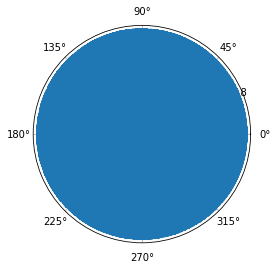

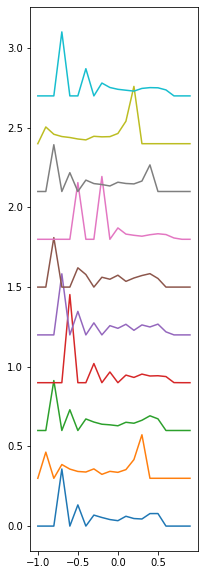

In [29]:
consensus = [assemblies.ConsensusAssembly(lst_assemblies, core_method="number")
             for lst_assemblies in zip(reference, *aligned)]
# print(consensus[0].gids)
print(len(consensus[0]))
print(len(consensus[0].union))
print(len(consensus[0].at_threshold(0.4)))
from matplotlib import pyplot as plt
plt.plot(consensus[0].union.gids, consensus[0].coreness, '.')
# plt.gca().plot(plt.gca().get_xlim(), [4.0, 4.0], ls='--')

plt.figure()
consensus[2].plot(marker='.', ms=0.1)

bins = numpy.linspace(-1, 1.0, 21)
coreness_hists = [numpy.histogram(c.coreness, bins=bins)[0] for c in consensus]
plt.figure(figsize=(3, 10))
for i, h in enumerate(coreness_hists):
    plt.plot(bins[:-1], h/h.sum() + 0.3 * i)

2. Which got aligned with which assembly?

In [ ]:
print("Reference seed is {0}\n".format(reference_name))
for assembly_group in aligned:
    print("\tAligned seed {0}".format(assembly_group.label))
    #  The assemblies in the reference remain unchanged, ordered from 1 to n. Hence we just enumerate 
    for i, assembly in enumerate(assembly_group):
        print("""\t\tAssembly #{0} of the reference is aligned
        \t\twith assembly {1} of the aligned seed""".format(i, assembly.idx)) #  Get the original index of the assembly by accessing.idx

Demonstrating reading / writing of assembly groups

In [ ]:
assemblies.AssemblyProjectMetadata.to_h5(metadata, "test.h5", prefix="assemblies/aligned")
reference.to_h5("test.h5", prefix="assemblies/aligned")
for assembly in aligned:
    assembly.to_h5("test.h5", prefix="assemblies/aligned")

re_read_data, re_read_metadata = utility.load_assemblies_from_h5("test.h5", prefix="assemblies/aligned")
re_read_reference = re_read_data[reference_name]
print("Reference seed is {0}\n".format(reference_name))
for re_read_aligned_name, re_read_aligned in re_read_data.items():
    if re_read_aligned_name == reference_name:
        continue
    print("\tAligned seed {0}".format(re_read_aligned.label))
    #  The assemblies in the reference remain unchanged, ordered from 1 to n. Hence we just enumerate 
    for i, assembly in enumerate(re_read_aligned):
        print("""\t\tAssembly #{0} of the reference is aligned
        \t\twith assembly {1} of the aligned seed""".format(i, assembly.idx)) #  Get the original index of the assembly by accessing.idx

3. Evaluate how good the alignment is

3a. In terms of relative overlap of all pairs of aligned assemblies

In [ ]:
ax = plt.figure(figsize=(5, 4)).gca()
ax.set_title("Reference: {0}".format(reference_name))

for assembly_grp in aligned:
    score = reference.evaluate_individual_alignments(assembly_grp, score_function="overlap")
    ax.plot(score, 'o', label=assembly_grp.label)
#plt.legend()
ax.set_xlabel("Assembly #")
ax.set_ylabel("Rel. overlap /w corresp. assembly (nrmlz.)")


3b. In terms of the correlations of their vectors of overlaps with all other assemblies in the reference group

In [ ]:
ax = plt.figure(figsize=(5, 4)).gca()
ax.set_title("Reference: {0}".format(reference_name))

for assembly_grp in aligned:
    #  The next line is the ONLY line different from the previous cell.
    score = reference.evaluate_individual_alignments(assembly_grp, score_function="correlation")
    ax.plot(score, 'o', label=assembly_grp.label)
#plt.legend()
ax.set_xlabel("Assembly #")
ax.set_ylabel("Rel. overlap /w corresp. assembly (nrmlz.)")

3c. In terms of the correlations of the profiles of overlap over all pairs of aligned assemblies

In [ ]:
# Note: the output of "evaluate_overall_alignment" is coming from a call to pearsonr. So the first
# values is the correlation, the second is the p-value. Here, we plot correlation, hence [0]
scores = [reference.evaluate_overall_alignment(assembly_grp)[0] for assembly_grp in aligned]
labels = [assembly_grp.label for assembly_grp in aligned]
ax = plt.figure(figsize=(5, 4)).gca()
ax.set_title("Reference: {0}".format(reference_name))

ax.bar(range(len(scores)), scores)
ax.set_xticks(range(len(scores)))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Pearsonr")

4. Building consensus assemblies. 
Before, we used one reference and aligned all other seeds to it. Now we do something more involved: 
We use each seed as reference once to get an alignment, then we build an overall consensus from each individual run!

The outputs are: 
1. The consensus assemblies, i.e. the union of all assemblies aligned to each other in the consensus.
2. the consensus core, i.e. the intersection of all assemblies aligned to each other in the consensus.
3. Information about which assemblies of which seed went into the consensus assemblies.

In [ ]:
# Note: Can also use score_function="overlap". In that case threshold needs to be adjusted to around maybe 65.
# Also: This takes a while to run.
cons_assemblies, cons_core, cons_props = \
utility.consensus_over_seeds(assembly_groups, score_function="correlation", threshold=0.94)

# looseness: How variable is a consensus assembly over seeds 
# (it is the ratio of the size of the union over the intersection)
#
# stability: What fraction of seeds does a consensus assembly appear in?
looseness, stability = utility.consensus_properties(cons_assemblies, cons_core, cons_props)